Load required libraries

In [88]:
import pyart
pyart.config.load_config('mch_config.py')
import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import glob

1. Load all radar files in /data/ALBIS_2021 and merge them into one single radar object

In [89]:
files_radar = sorted(glob.glob('./data/ALBIS_2021/MLA211941205*'))
for i,f in enumerate(files_radar):
    radar = pyart.io.read_cfradial(f)
  
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)

temp = pyart.io.read_cfradial('./data/ALBIS_2021/20210713120500_savevol_COSMO_LOOKUP_TEMP.nc')        
radar_merged.add_field('temperature', temp.fields['temperature'])

2. Perform attenuation correction of ZH, using a constant freezing level height of 2700 m.

In [90]:
# Compute attenuation
out = pyart.correct.calculate_attenuation_zphi(radar_merged, fzl = 4200,
                           phidp_field = 'uncorrected_differential_phase',
                           temp_field = 'temperature',
                           temp_ref = 'temperature')
spec_at, pia, cor_z, spec_diff_at, pida, cor_zdr = out
radar_merged.add_field('corrected_reflectivity', cor_z)


3. Estimate the QPE with a __[a polynomial Z-R relation](https://arm-doe.github.io/pyart/_modules/pyart/retrieve/qpe.html#est_rain_rate_za)__.

In [91]:
qpe = pyart.retrieve.est_rain_rate_zpoly(radar_merged, refl_field = 'corrected_reflectivity')

radar_merged.add_field('radar_estimated_rain_rate', qpe)

4. Compute a CAPPI of the resulting radar estimate rain rate from 500 to 8000 m above the radar  using a vertical resolution of 100 m and a horizontal resolution of 500 m at a x and y distance of up to 100 km to the radar.

In [92]:
zmin = 500
zmax = 8000
ymin= xmin = -100000
ymax = xmax = 100000
lat = float(radar.latitude['data'])
lon = float(radar.longitude['data'])
alt = float(radar.altitude['data'])
# number of grid points in cappi
cappi_res_h = 500
cappi_res_v = 100
ny = int((ymax-ymin)/cappi_res_h)+1
nx = int((xmax-xmin)/cappi_res_h)+1
nz = int((zmax-zmin)/cappi_res_v)+1

cappi_qpe = pyart.map.grid_from_radars(radar_merged, grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax),
                     (xmin, xmax)),
        fields=['radar_estimated_rain_rate'])

5. Using numpy, perform a weighted average of all CAPPI levels using the weights. Finally display the results.

/tmp/ipykernel_6091/2553980288.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(cappi_qpe.point_longitude['data'][0],


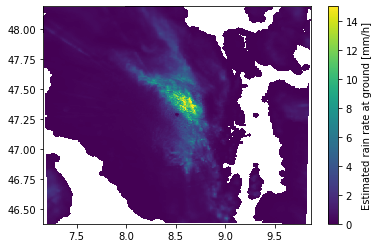

In [93]:
weighting = np.exp(-0.5*  cappi_qpe.z['data'] / 1000)

qpe_ground = weighting[:,None,None]*cappi_qpe.fields['radar_estimated_rain_rate']['data']
qpe_ground = np.nansum(qpe_ground, axis = 0) / np.sum(weighting)

plt.pcolormesh(cappi_qpe.point_longitude['data'][0], 
               cappi_qpe.point_latitude['data'][0],
               qpe_ground, vmax = 15)
plt.colorbar(label = 'Estimated rain rate at ground [mm/h]')

Now let's compare this QPE with the operational QPE of MeteoSwiss at the same timestep:

<div>
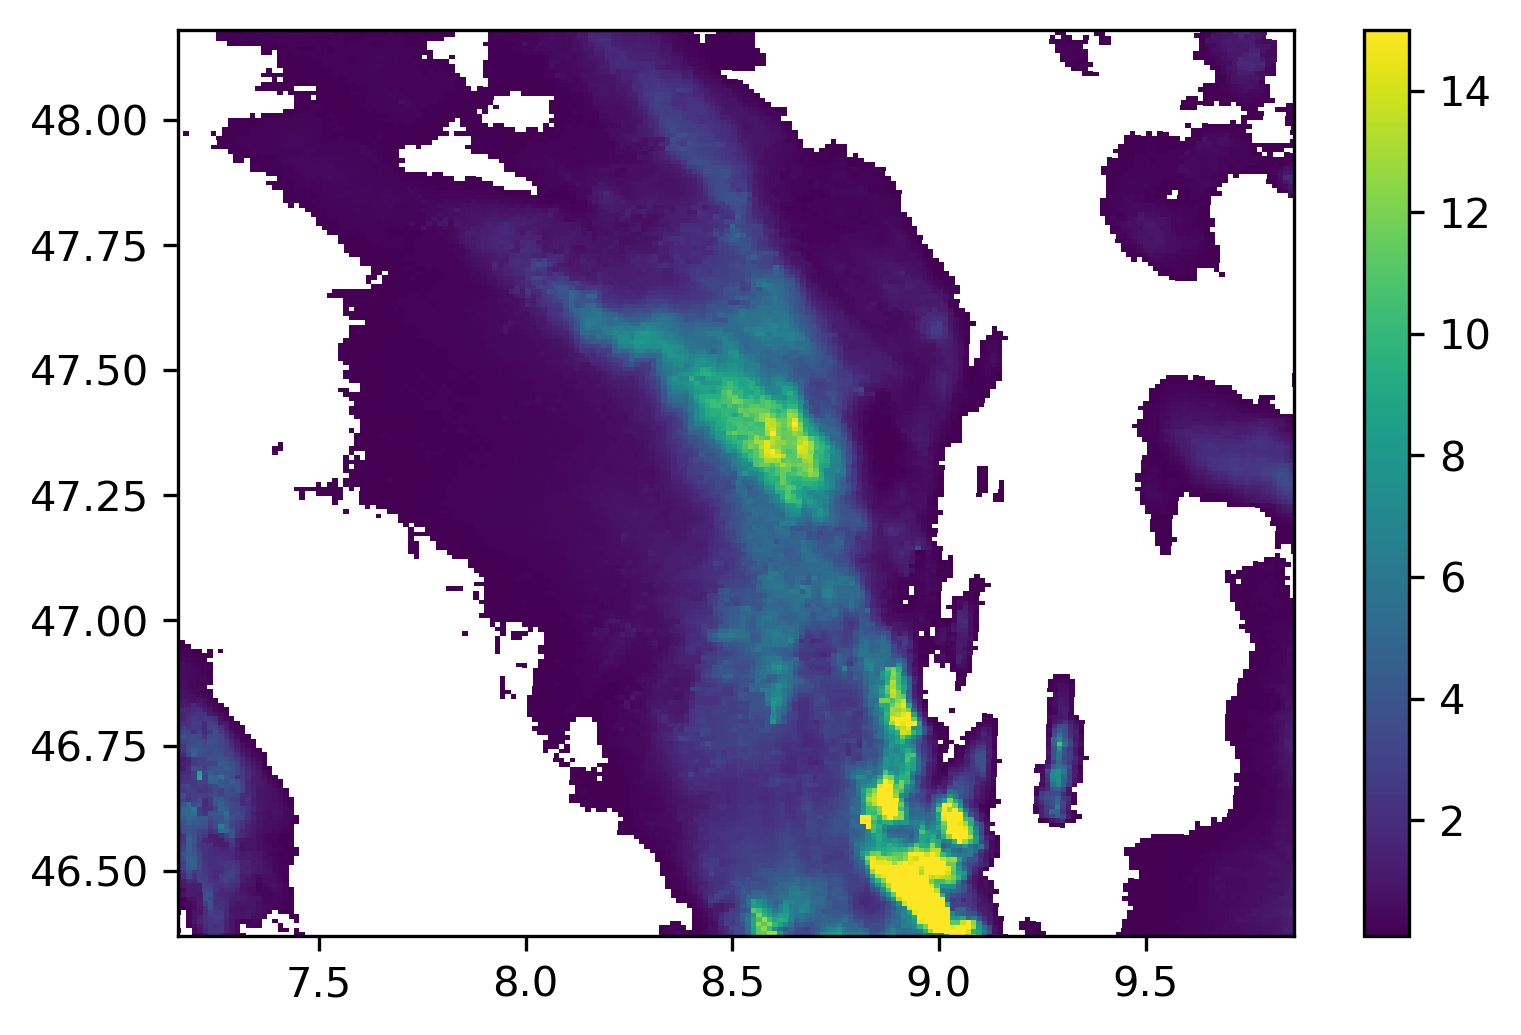
</div>

The agreement near the radar is not too bad, even with such a simple aggregation method. In the south we see some large discrepancies. This is due to the fact that the operational QPE includes many additional steps. In this case, the difference is likely due to the correction for partial beam blocking that is performed by the operational QPE in this mountaineous region south of the radar.